# ECG Preprocessing

This tutorial covers the primary steps needed to preprocess ECG data in preparation for training a classifier to determine if the data comes from the person of interest or not. We begin with a typical ECG recording contaminated with noise from common sources and end with clean, individually segmented beats. This material follows closely from the great work of Nikit Samarin (see reference below), so please refer to his report for additional details. 

We begin this tutorial with an overview of the steps involved and then move on to a demonstration with actual code (written in Python3). 

# Filtering Common ECG Noise Sources

A large body of literature exists for detailing the many methods of filtering noise from ECG signals. These include IIR filters, FIR filters, adaptive filters, discrete wavelet transforms, bionic wavelet transforms, empirical mode decomposition, etc. The choice of filtering method depends on the type of analysis being performed, and more sensitive analyses of the full PQRST complex require more sophisticated filtering approaches. Since our goal is to detect and localized the R peak and segment the individual heartbeats, we can adopt a more basic approach.  

For a more comprehensive overview of common noise sources that affect ECG data, see the ECG_Noise_Sources tutorial in this project.

## Butterworth Filter

We will assume that the ECG data is collected from our patients under controlled conditions when the patients are at rest and relatively immobile. Thus, we can assume that EMG and electrode motion noise is held at a minimum. Our primary concerns then are baseline drift at the low frequency end and powerline noise at the higher frequency end. Since the frequency band of the PQRST complex lies in the middle of this region, we can use a simple bandpass filter to reject noise outside of the desired band. We will use a third-order Butterworth filter for this purpose, the frequency response for which is shown below. This filter is designed to reject frequencies below 1 Hz and above 20 Hz.  

![image.png](images/butterworthFreqResponse.png)
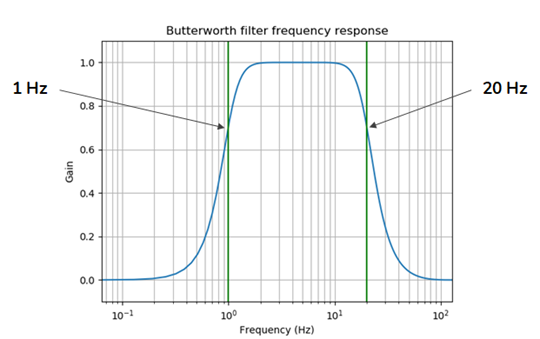

We can see the effects of applying this filter to a noisy ECG signal in the figures below (original noisy signal on the left, filtered signal on the right).

![image.png](images/rawAndFilteredECG.png)
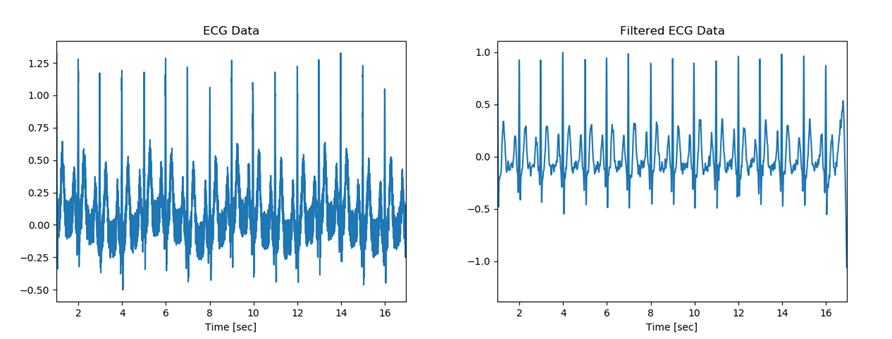

## Wavelet Decomposition

Having filtered out much of the noise, our next objective is to locate the R peaks in the individual heart beats (i.e., the PQRST complexes). The first step will be to apply a wavelet decomposition using the sym4 wavelet. The sym4 wavelet (shown below in red) is chosen because it is very similar in shape to the QRS complex (shown below in blue). When this wavelet is convolved with the ECG signal, it produces a peak in the resulting waveform when it lines up with a portion of the ECG signal that is close in appearance to the wavelet. In this respect, this wavelet decomposition acts much like a matched filter. Wavelet decomposition will actually perform this convolution several times with sym4 wavelet functions of different widths to explore different frequency ranges. We just need to select the output frequency range that shows the strongest peaks. Looking at the figure below showing the resulting waveforms for the different frequency ranges, it appears that the range labeled "A1" is best.

![image.png](images/sym4_DWT.png)
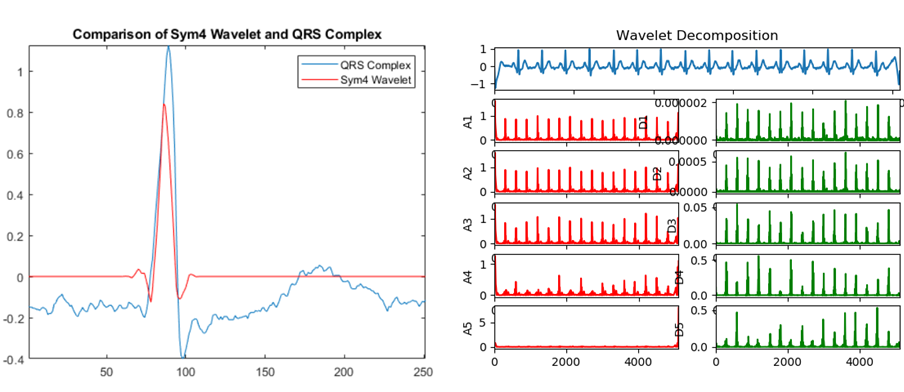

## Gradient

Wavelet decomposition provides good coarse estimates of the R peak locations, but we will need to refine these estimates in order to obtain high accuracy for our goal of segmenting the individual heart beats properly. To improve our estimates, we will take the gradient of our wavelet-processed waveform to localize those places where the signal rises sharply then falls sharply. The gradient response is shown in red below (with the wavelet decomposition in blue). 

![image.png](images/gradient.png)
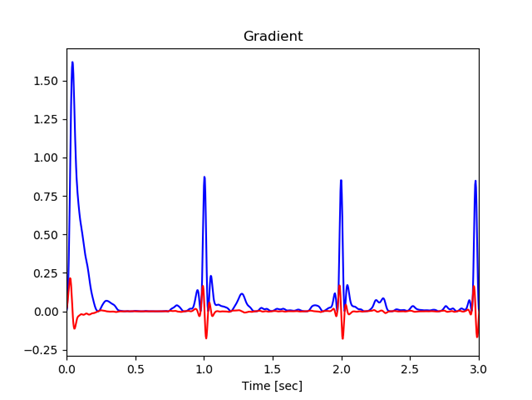

## Peak Detection

Searching the gradient response for where the response has the largest sample-to-sample changes, we can finally locate the R peaks. The outputs of this search are shown as the red dots in the figure below, where we see that the search has succeeded in accurately locating the R peaks.

![image.png](images/peakDetection.png)
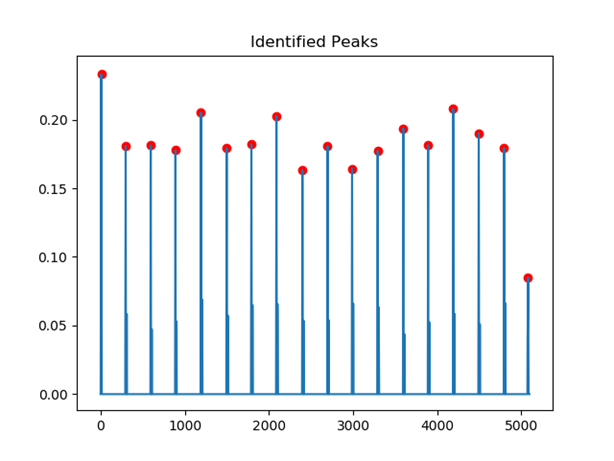

## Heartbeat Segmentation

The final step, now that the R peaks have been located, is to segment the individual heartbeats. We do this by calculating the average distance between successive peaks and then dividing this distance into thirds. For each R peak, we extract all samples starting from one third of the average distance before the peak to two thirds of this distance after. The resulting segmented beats are shown below.

![image.png](images/segmentedBeats.png)
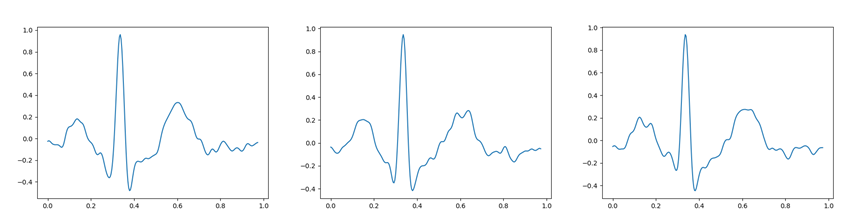

# Implementing ECG Preprocessing in Python3

We begin by importing useful Python libraries that we will make use of in our ECG preprocessing implementation.

In [24]:
%matplotlib inline
import os
import yaml
import pywt
import numpy as np
import pandas as pd
from scipy import signal
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

Next, we provide some details about our ECG recordings. Specifically, we need to provide the sampling rate to ensure proper computation of frequency information and a maximum heart rate to bound the segmentation process.

In [46]:
sampleRate = 256  # Hz
maxHeartRate = 200  # bpm
windowSize = int(sampleRate / (maxHeartRate/60.0))

For this tutorial we will use a simulated ECG recording as our data source. The recording is stored in the first row of the csv file located in the same folder as this tutorial.

In [26]:
rawData = pd.read_csv('./ecgsyn_data.csv', header=None).iloc[0]

Let's plot the raw data to see what we are dealing with.

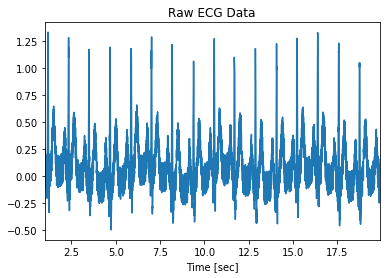

In [27]:
def plotData(data, title):
    plt.figure()
    time = np.arange(len(data)) * (1.0/float(sampleRate))
    plt.plot(time, data)
    plt.xlabel('Time [sec]')
    plt.title(title)
    plt.xlim([1.0, time[-10]])
    plt.show()
    
plotData(rawData, 'Raw ECG Data')

Now we are ready to being preprocessing the ECG data. Our first step is to filter out noise. For this we will create a third-order Butterworth filter with a bandpass region from 1 Hz to 20 Hz.

In [28]:
fn = 0.5 * sampleRate   # Nyquist frequency
f_low = 1.0/fn
f_high = 20.0/fn
b, a = signal.butter(3, [f_low, f_high], 'bandpass')
w, h = signal.freqz(b, a, worN=2000)
filtData = signal.filtfilt(b, a, data)

Plotting this result, we can see that the majority of the noise present in the ECG recording has indeed been removed.

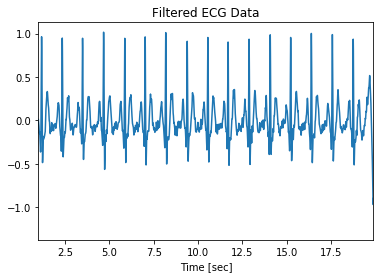

In [29]:
plotData(filtData, 'Filtered ECG Data')

Now we use the pywt Python library to create the sym4 waveform that we will use as a matched filter to conduct a coarse localization of the R peaks.

In [30]:
w = pywt.Wavelet('sym4')

With this wavelet, we will apply the Discrete Wavelet Transform (DWT) to convolve the wavelet with the ECG data.

In [31]:
mode = pywt.Modes.smooth
(coeff, d) = pywt.dwt(filtData, w, mode)
coeff_list = [coeff, None]
transformedData = pywt.waverec(coeff_list, w)

We can examine the outcome of this step by plotting the coefficients produced by this transform. The plots below the waveform show the coefficients that result for each frequency band in the DWT. Notice that the A1 coefficients provide the strongest and most consistent result.

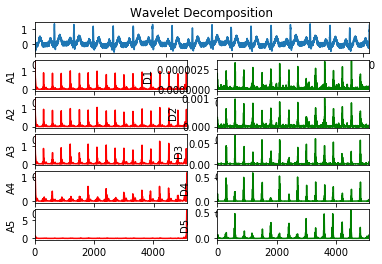

In [34]:
a = filtData
ca = []
cd = []
for i in range(5):
    (a, d) = pywt.dwt(a, w, pywt.Modes.smooth)
    ca.append(a)
    cd.append(d)

rec_a = []
rec_d = []

for i, coeff in enumerate(ca):
    coeff_list = [coeff, None] + [None] * i
    rec_a.append(np.power(pywt.waverec(coeff_list, w), 2))

for i, coeff in enumerate(cd):
    coeff_list = [None, coeff] + [None] * i
    rec_d.append(np.power(pywt.waverec(coeff_list, w), 2))

fig = plt.figure()
ax_main = fig.add_subplot(len(rec_a) + 1, 1, 1)
ax_main.set_title('Wavelet Decomposition')
ax_main.plot(data)
ax_main.set_xlim(0, len(data) - 1)

for i, y in enumerate(rec_a):
    ax = fig.add_subplot(len(rec_a) + 1, 2, 3 + i * 2)
    ax.plot(y, 'r')
    ax.set_xlim(0, len(y) - 1)
    ax.set_ylabel("A%d" % (i + 1))

for i, y in enumerate(rec_d):
    ax = fig.add_subplot(len(rec_d) + 1, 2, 4 + i * 2)
    ax.plot(y, 'g')
    ax.set_xlim(0, len(y) - 1)
    ax.set_ylabel("D%d" % (i + 1))

To accentuate the wavelet decomposition results, we will square the transformed data.

In [35]:
squaredTransformedData = np.power(transformedData, 2)

The DWT results provide good coarse R peak location estimates, but to improve this localization, we will calculate the gradient of the squared transformed signal.

In [41]:
gradData = np.gradient(squaredTransformedData)

The gradient (red) is plotted against the squared transformed waveform (blue) below.

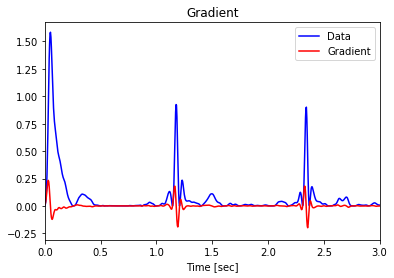

In [43]:
plt.figure()
plt.plot(time, squaredTransformedData, 'b', label='Data')
plt.plot(time, gradData, 'r', label='Gradient')
plt.xlabel('Time [sec]')
plt.title('Gradient')
plt.xlim([0,3])
plt.legend(loc='best')
plt.show()

The tops of the R peaks can now be identified by finding the locations where the gradient passes through zero after starting from a high positive value and ending on a large negative value. We do this by calculating the differences between successive points for the entire waveform and then keeping only those points that exceed a two standard deviation threshold.

In [55]:
diffs = np.diff(gradData)
meanDiff = np.mean(diffs)
stdDiff = np.std(diffs)
threshold = meanDiff + 2.0 * stdDiff
peaks = gradData
peaks[gradData < threshold] = 0.0
peakInds = []
# Find the indices that correspond to the R peaks
for i in range(0,len(peaks), windowSize):
  window = peaks[i:i+windowSize]
  if sum(window) > 0.0:
    maxInd, = list(np.where(window == np.max(window)))
    peakInds.append(i + maxInd[0])
# Remove false peaks
indsToRemove = []
for i in range(1,len(peakInds)):
  if peakInds[i] - peakInds[i-1] < windowSize:
    indsToRemove.append(peakInds[i]) if peaks[peakInds[i]] <= peaks[peakInds[i-1]] else indsToRemove.append(peakInds[i-1])
peakInds = [x for x in peakInds if x not in indsToRemove]

The identified R peak locations are shown as the red dots in the plot below.

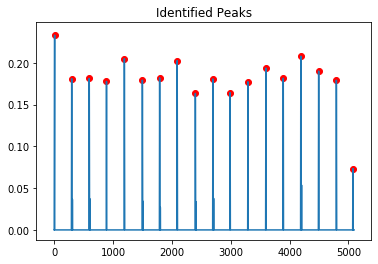

In [56]:
plt.figure()
plt.plot(range(len(peaks)), peaks)
plt.scatter(peakInds, peaks[peakInds], c='r')
plt.title('Identified Peaks')
plt.show()

Having located the R peaks, we have reached the final step which is to segment the individual beats. We do this by calculating the average time between R peaks, and dividing it into thirds. For each R peak, we define the heart beat as starting one third of this time before the R peak and ending two thirds of this time afterward. We finish be resampling each heart beat to 250 points in preparation for input to the classifier.

In [60]:
# Determine average distance between peaks
meanDist = int(np.mean(np.diff(peakInds)))
thirdDist = int(np.round(meanDist/3.0))
# Initialize data dictionary
beatsDF = pd.DataFrame(index=[])
# Loop over the peak indices and segment the beats
for k, pk in enumerate(peakInds):
  startInd = np.max([0, pk - thirdDist])
  stopInd = np.min([startInd+meanDist, len(filtData)-1])
  beat = filtData[startInd:stopInd]
  # Throw out the first and last peaks
  if k == 0 or k == len(peakInds)-1:
    continue
  else:
    # Resample to 250 points
    f = interp1d(np.linspace(0, 1, beat.size), beat, 'linear')
    resampledBeat = f(np.linspace(0, 1, 250))
    beatsDF = beatsDF.append(pd.Series(resampledBeat, index=range(250), name=str(k)))

The first three beats are plotted below.

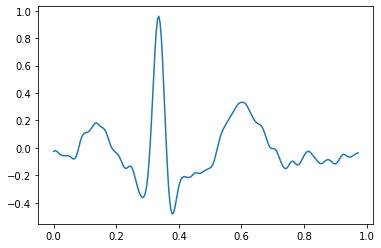

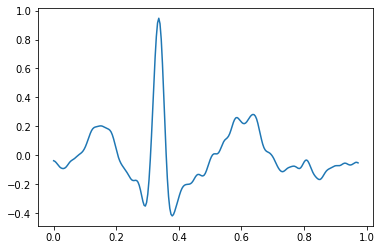

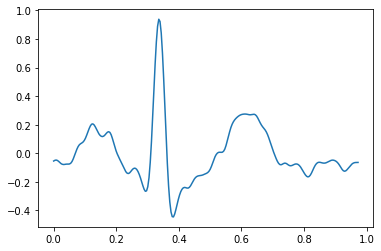

In [64]:
for i in range(3):
    plt.figure()
    beat = beatsDF.iloc[i]
    time = np.arange(len(beat)) * (1.0/float(sampleRate))
    plt.plot(time, beat)

## References

1. Nikita Samarin, "A Key to Your Heart: Biometric Authentication Based on ECG Signals," 4th Year Project Report, University of Edinburgh, 2018.
